# AI 2 Trust Hypothesis

## Imports

In [1]:
# import pandas module 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Functions

In [2]:
# count answers
def create_list(ans_column):
    ans_dist = [ sum(df[ans_column] == 1),
                 sum(df[ans_column] == 2),
                 sum(df[ans_column] == 3),
                 sum(df[ans_column] == 4),
                 sum(df[ans_column] == 5), ]
    return ans_dist

# count answers two categories
def create_list_bi(ans_column):
    ans_dist = [ sum(df[ans_column] == 1) +  sum(df[ans_column] == 2) +  sum(df[ans_column] == 3),
                 sum(df[ans_column] == 4) +  sum(df[ans_column] == 5), ]
    return ans_dist


# create survey results chart
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

# functions used in notebook
def check_pvalue(p_df, p_imetric, p_di_isnb, p_di_nonb, p_hx):
    """
    This function takes the game results and identifies the last move of the game that lead to a loss and
    then reverse the move.  The output is a dataframe containing moves that needs to be improved.
    This will form part of the training data.
    
    parameters: inr_of_game (int) number of games
                inr_of_files (int) number of files in which the games will be split up
                player_1 (char1) player x type, U for untrained, S for trained and L for trained further
                player_2 (char1) player o type, U for untrained, S for trained and L for trained further
                i_print_board (boolean) True if the board state should be printed
    return: filename (string) name of file that was created        
    """
    
    # create new dataframe that will be used
    p_df_new = p_df[[p_imetric]].copy()
    p_df_new.loc[:, 'isnb'] = p_df_new.loc[:, p_imetric]
    p_df_new.loc[:, 'nonb'] = p_df_new.loc[:, p_imetric]

    # code data
    p_df_new = p_df_new.replace({"isnb": p_di_isnb})
    p_df_new = p_df_new.replace({"nonb": p_di_nonb})

    # drop na
    p_df_new = p_df_new.dropna()

    # 1 calcualte observed differences
    p_obs_diff = p_df_new['isnb'].sum() - p_df_new['nonb'].sum()

    # 2 - create sampling distribution of difference between isnb and nonb
    diffs = []
    for _ in range(10000):
        df_sample = p_df_new.sample(p_df_new.shape[0], replace = True)
        sample_diff = df_sample['isnb'].sum() - df_sample['nonb'].sum()

        diffs.append(sample_diff)    
        
    diffs = np.array(diffs)        
    
    # 3 - simulate distribution under the null hypothesis
    null_vals = np.random.normal(0, diffs.std(), diffs.size)    
    
    # plot null distribution
    plt.hist(null_vals);

    # plot line for observed statistic
    plt.axvline(x=p_obs_diff, color='red');    
    
    plt.show()
    
    # compute p value
    p_value = (null_vals > p_obs_diff).mean()
    
    print(p_hx, p_imetric)    
    print('p-value:', p_value)
    if p_value < 0.001:      
        print('reject H0')
    else:
        print('fail to reject H0')

    print('----')    
    print('')       
    
    return p_value


# function to create word cloud 
def create_wordcloud(df_cloud, i_column):
    """ 
    creates a wordcload based on a dataframe column as input. 

    Parameters: 
    df_main (data frame): dataframe containing data
    i_column (string): Column 

    Returns: 
    int: wordcloud

    """
    
    # get the text 
    df_text = df_cloud.dropna(subset=[i_column]) 
    df_text = df_text[i_column]

    # take dataframe and put in text
    text = " ".join(itext for itext in df_text)

    stopwords = set(STOPWORDS)
    stopwords.update(["AI", "system", "organization", 'application', 'one',  "will", "need", 'without', 'something', 'make',
                       'based', 'stay', 'add', 'day', 'still', 'ie', 'way', 'made'])

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=30, background_color="white").generate(text)

    # Display the generated image:
    plt.figure(figsize=(30, 20))    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Prepare Data

In [3]:
# import header file
df = pd.read_excel('http://www.d5mit.co.za/artifacts/output.xlsx')

df = df[df['ai_transparency_to_trust'].notna()]

df.drop('email', axis='columns', inplace=True)
df.drop('first_name', axis='columns', inplace=True)
df.drop('last_name', axis='columns', inplace=True)
df.drop('custom_data', axis='columns', inplace=True)

df = df[df['ai_fat_to_trust'].notna()]

In [4]:
df.describe()

,Unnamed: 0,resp_id,colle_id,d_tools,d_capabilities,d_culture,d_acts_on_data,d_fin_benefits,d_non_fin_benefits,m_maturity_rating,...,sy_fairness_to_trust,sy_trust_to_adoption,sy_lack_trust_low_adoption,ai_transparency_to_trust,ai_accountability_to_trust,ai_fairness_to_trust,ai_trust_to_adoption,ai_lack_trust_low_adoption,ai_must_be_trans_expl,ai_fat_to_trust
count,135.000000,1.350000e+02,135.0,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,...,135.000000,135.000000,135.000000,135.000000,134.000000,135.000000,134.000000,135.000000,135.000000,135.000000
mean,69.503704,1.288961e+10,404063954.0,4.229630,4.429630,4.355556,4.325926,4.377778,4.288889,67.925926,...,4.259259,4.555556,4.592593,4.081481,4.365672,4.185185,4.485075,4.562963,4.466667,4.562963
std,39.626027,3.987321e+06,0.0,0.854669,0.728326,0.786705,0.827058,0.771379,0.780993,21.394877,...,0.679804,0.581643,0.746097,0.970089,0.710195,0.848046,0.597426,0.593590,0.620544,0.580882
min,1.000000,1.288637e+10,404063954.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,...,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000
25%,35.500000,1.288657e+10,404063954.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,50.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,69.000000,1.288914e+10,404063954.0,4.000000,5.000000,4.000000,4.000000,5.000000,4.000000,72.000000,...,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000
75%,103.500000,1.288938e+10,404063954.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,85.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,138.000000,1.289784e+10,404063954.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,100.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Data Exploration

The questions are in the context of implementing AI applications.



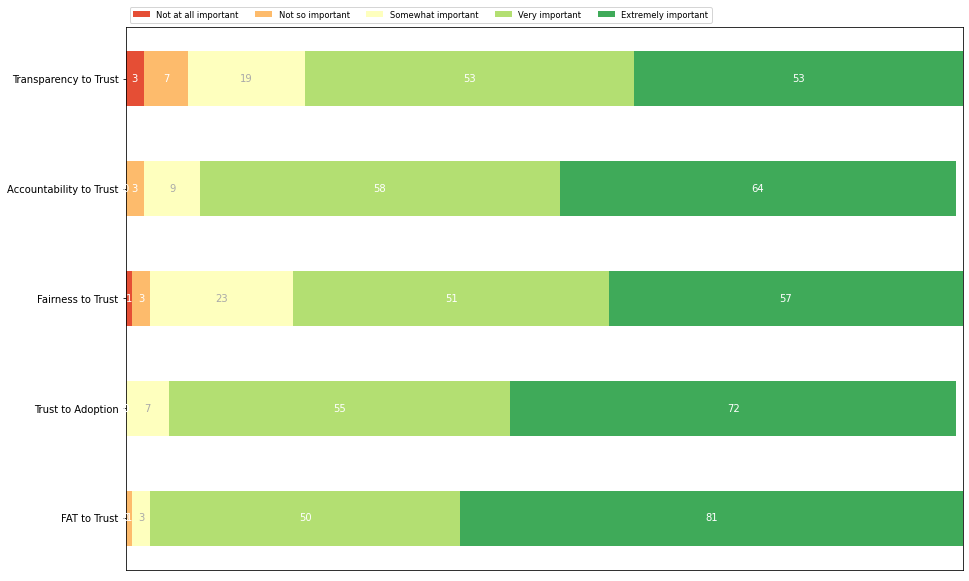

In [5]:
# Distribution of answers
category_names = ['Not at all important','Not so important','Somewhat important','Very important','Extremely important']

results = {
    'Transparency to Trust': create_list('ai_transparency_to_trust'),
    'Accountability to Trust': create_list('ai_accountability_to_trust'),
    'Fairness to Trust': create_list('ai_fairness_to_trust'),
    'Trust to Adoption': create_list('ai_trust_to_adoption'),
    'FAT to Trust': create_list('ai_fat_to_trust'),
}

survey(results, category_names)
plt.show()

## Creating H1-H5

<strong>H1: 
ai_transparency_to_trust </strong>
<br>Question: 
From a product owner perspective, do you think the transparency of an AI application's logic is important/beneficial for trustworthiness? Transparency is, for example, the explainability of the machine learning decision/predictive process.
<br><br>
<strong>H2: 
ai_accountability_to_trust </strong>
<br>Question: 
From a product owner perspective, do you think assigning accountability of a AI application's actions is important/beneficial for trustworthiness? Accountability would be, for example, who is accountable when an autonomous vehicle crashes.
<br><br>
<strong>H3: 
ai_fairness_to_trust</strong>
<br>Question: 
From a product owner perspective, do you think the fairness of the AI application's actions is important for trustworthiness. For example, demographic biases in the automation of credit vetting.
<br><br>
<strong>H4: 
ai_trust_to_adoption </strong>
<br>Question: 
From a product owner perspective, is trustworthiness an important contributor to the adoption of the system?
<br><br>
<strong>H5: 
ai_fat_to_trust </strong>
<br>Question: 
Ensuring that AI applications are fair, accountable and transparent, will lead to more trust.
<br><br>

<strong>Answeres mapped into groups:</strong>
<table>
    <tr>
        <th>Value Text</th>
        <th>Number</th>
        <th>di_isnb</th>   
        <th>di_nonb</th>         
    </tr>
    <tr>
        <td>Extremely important</td>
        <td>5</td>
        <td>1</td>        
        <td>0</td>                
    </tr>
    <tr>
        <td>Very important</td>
        <td>4</td>
        <td>1</td>        
        <td>0</td>                        
    </tr>
    <tr>
        <td>Somewhat important</td>
        <td>3</td>
        <td>0</td>        
        <td>1</td> 
    </tr>
    <tr>
        <td>Not so important</td>
        <td>2</td>
        <td>0</td>
        <td>1</td>        
    </tr>    
    <tr>
        <td>Not at all important</td>
        <td>1</td>
        <td>0</td>  
        <td>1</td>        
    </tr>    
</table>    


    

<i>Other</i><br>
<strong>H4b: 
ai_lack_trust_low_adoption</strong>
<br>Question: 
A lack of trust in the process around an AI system will lead to a lower level of adoption of the AI application.
<br><br>
<strong>H6: 
ai_must_be_trans_expl</strong>
<br>Question: 
Organisations need to ensure that the AI applications that they develop are transparent (allow explainability) in their actions.
<br><br>
<strong>What other ethical considerations: 
ai_ethical_considerations</strong>
<br>Question: 
If any, what ethical considerations other than fairness, transparency and accountability should organisations have when they develop AI applications?
<br><br>
<br>

<img src='images/TOEFAT_H.jpg'>

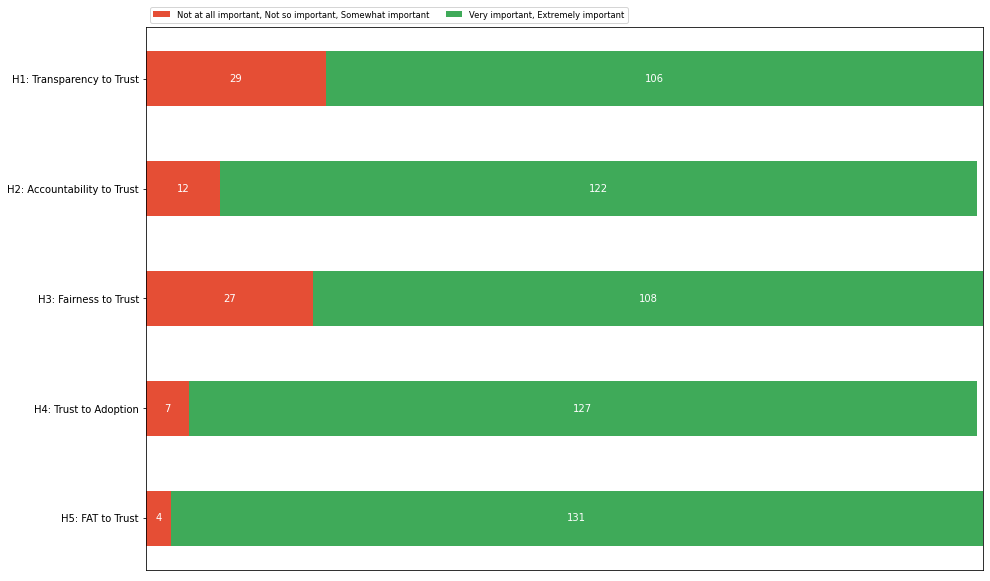

In [6]:
# Distribution of answers
category_names = ['Not at all important, Not so important, Somewhat important','Very important, Extremely important']

results = {
    'H1: Transparency to Trust': create_list_bi('ai_transparency_to_trust'),
    'H2: Accountability to Trust': create_list_bi('ai_accountability_to_trust'),
    'H3: Fairness to Trust': create_list_bi('ai_fairness_to_trust'),
    'H4: Trust to Adoption': create_list_bi('ai_trust_to_adoption'),
    'H5: FAT to Trust': create_list_bi('ai_fat_to_trust'),
}

survey(results, category_names)
plt.show()

## H1: ai_transparency_to_trust

<strong>Hypothesis</strong><br>
H0: isnb - nonb = 0 <br>
H1: isnb - nonb > 0 <br>  

In [7]:
# set H1 field
imetric = 'ai_transparency_to_trust'

# create dictionary with mappings
di_isnb = {5: 1, 4: 1, 3: 0, 2: 0, 1: 0}
di_nonb = {5: 0, 4: 0, 3: 1, 2: 1, 1: 1}

#### 1. Prepare data

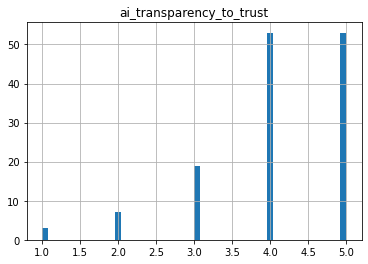

In [8]:
hist = df[[imetric]].hist(bins=50)

In [9]:
# create new dataframe that will be used
df_new = df[[imetric]].copy()
df_new.loc[:, 'isnb'] = df_new.loc[:, imetric]
df_new.loc[:, 'nonb'] = df_new.loc[:, imetric]

# code data
df_new = df_new.replace({"isnb": di_isnb})
df_new = df_new.replace({"nonb": di_nonb})

# drop na
df_new = df_new.dropna()

# output data
df_new.head()

,ai_transparency_to_trust,isnb,nonb
0,4.0,1.0,0.0
1,3.0,0.0,1.0
3,4.0,1.0,0.0
4,3.0,0.0,1.0
5,5.0,1.0,0.0


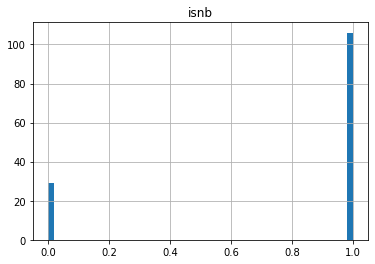

In [10]:
hist = df_new[['isnb']].hist(bins=50)

#### 2. Computed the observed difference

In [11]:
obs_diff = df_new['isnb'].sum() - df_new['nonb'].sum()
print(obs_diff)

77.0


#### 3. Simulate the sampling distribution.

In [12]:
# create sampling distribution of difference between isnb and nonb
diffs = []
for _ in range(10000):
    df_sample = df_new.sample(df_new.shape[0], replace = True)
    sample_diff = df_sample['isnb'].sum() - df_sample['nonb'].sum()

    diffs.append(sample_diff)

In [13]:
# std of simulated differences
diffs = np.array(diffs)
diffs.std()

9.562853456997027

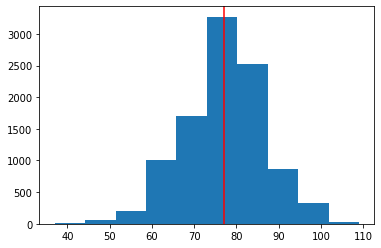

In [14]:
# plot sampling distribution
plt.hist(diffs);
plt.axvline(x=obs_diff, color='red');

#### 4. Simulate the distribution under the null hypothesis

In [15]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

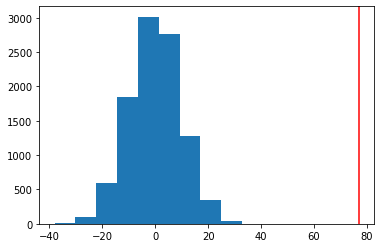

In [16]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(x=obs_diff, color='red');

#### 5. Compute the p-value 

In [17]:
# compute p value
p_value = (null_vals > obs_diff).mean()
print(p_value)

0.0


In [18]:
# P < 0.05 -> statistically significant
# P < 0.01 -> 
# P < 0.001 -> statistically highly significant

if p_value < 0.001:      #  statistically highly significant as P < 0.001 
    print('reject H0')
else:
    print('fail to reject H0')

reject H0


## Calculate P-value for all H and test H0

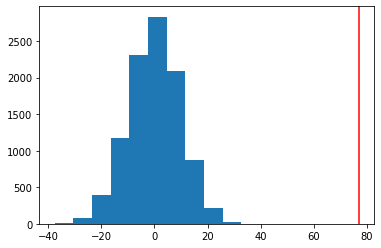

H1:  ai_transparency_to_trust
p-value: 0.0
reject H0
----



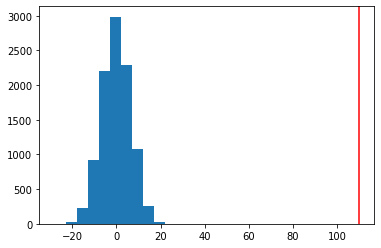

H2:  ai_accountability_to_trust
p-value: 0.0
reject H0
----



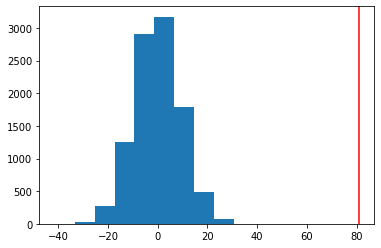

H3:  ai_fairness_to_trust
p-value: 0.0
reject H0
----



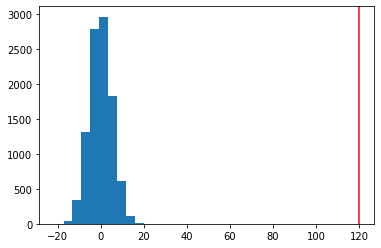

H4:  ai_trust_to_adoption
p-value: 0.0
reject H0
----



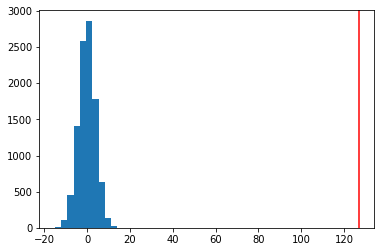

H5:  ai_fat_to_trust
p-value: 0.0
reject H0
----



In [19]:
# H1: ai_transparency_to_trust
imetric = 'ai_transparency_to_trust'
hx = 'H1: '
p_value = check_pvalue(df, imetric, di_isnb, di_nonb, hx)
 
# H2: ai_accountability_to_trust
imetric = 'ai_accountability_to_trust'
hx = 'H2: '
p_value = check_pvalue(df, imetric, di_isnb, di_nonb, hx)

# H3: ai_fairness_to_trust
imetric = 'ai_fairness_to_trust'
hx = 'H3: '
p_value = check_pvalue(df, imetric, di_isnb, di_nonb, hx)

# H4: ai_trust_to_adoption
imetric = 'ai_trust_to_adoption'
hx = 'H4: '
p_value = check_pvalue(df, imetric, di_isnb, di_nonb, hx)

# H5: ai_fat_to_trust
imetric = 'ai_fat_to_trust'
hx = 'H5: '
p_value = check_pvalue(df, imetric, di_isnb, di_nonb, hx)


### Other Ethical considerations

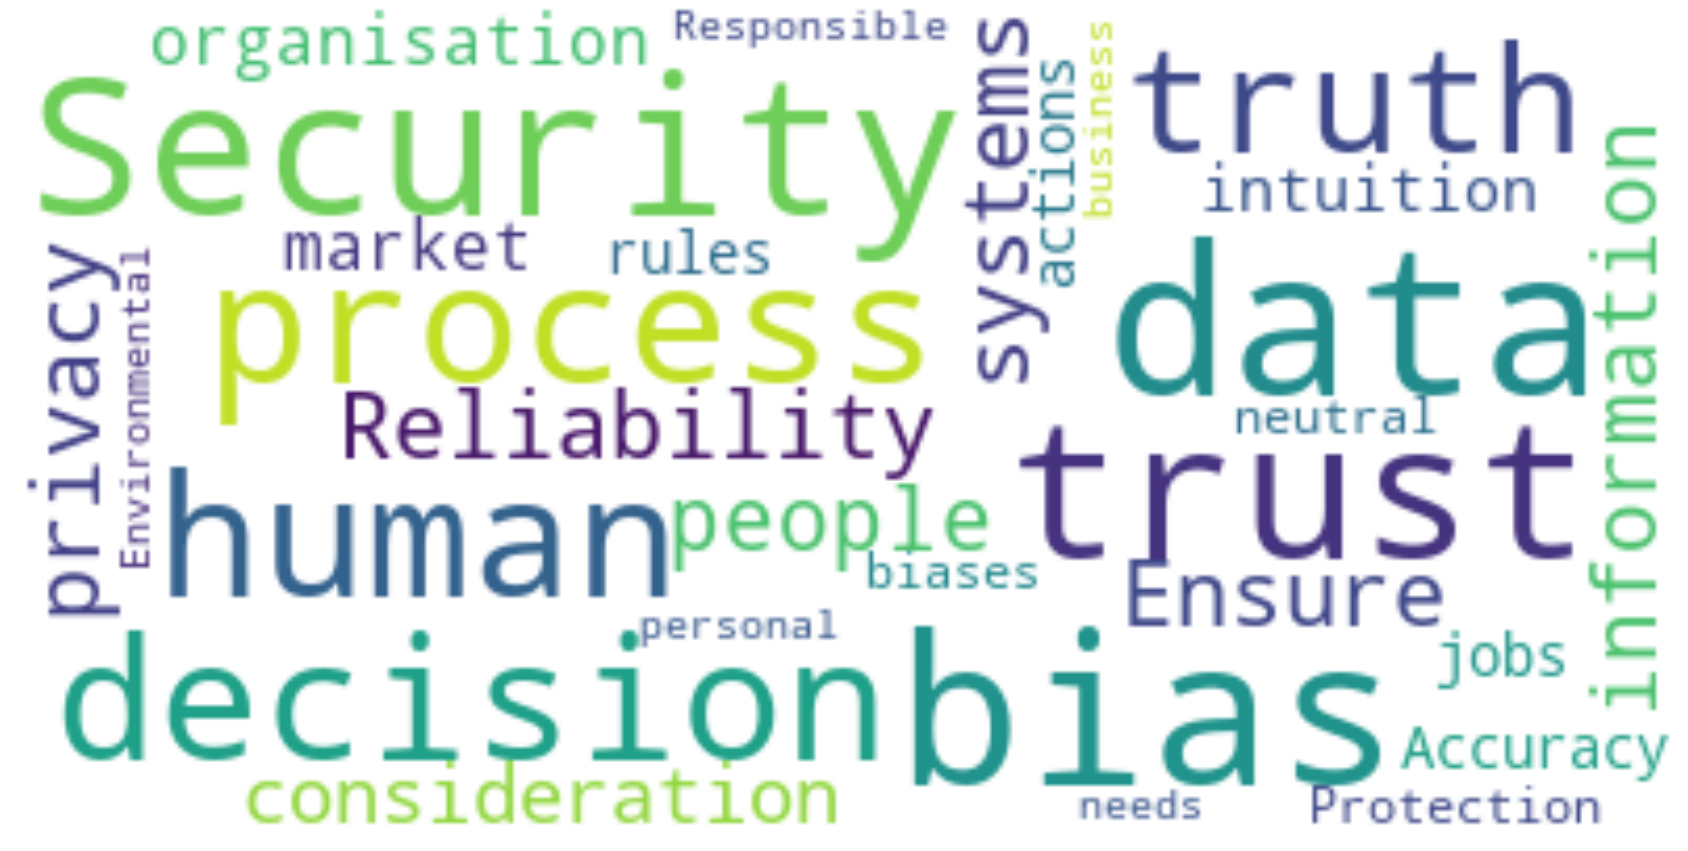

In [20]:
create_wordcloud(df, 'ai_ethical_considerations')